In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

In [1]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.2.0'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [3]:
mnist = pd.read_csv("local/data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]/255.
y=mnist[:,0]
print("dimension de las imagenes y las clases", X.shape, y.shape)

dimension de las imagenes y las clases (1500, 784) (1500,)


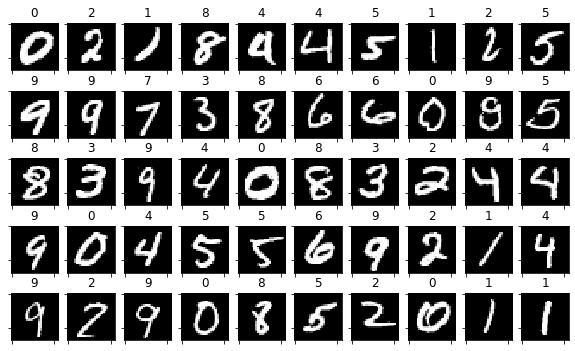

In [4]:
perm = np.random.permutation(list(range(X.shape[0])))[0:50]
random_imgs   = X[perm]
random_labels = y[perm] 
fig = plt.figure(figsize=(10,6))
for i in range(random_imgs.shape[0]):
    ax=fig.add_subplot(5,10,i+1)
    plt.imshow(random_imgs[i].reshape(28,28), interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_title(int(random_labels[i]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Autoencoder with small (sparse) activations

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [6]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.regularizers import l1
import tensorflow as tf

## Implement the following loss function

given:

- $k=50$, latent dimension
- $\mathbf{x}^{(i)} \in \mathbb{R}^{784}$
- $e(\mathbf{x}^{(i)}) \in \mathbb{R}^{k}$, the encoder
- $d(e(\mathbf{x}^{(i)})) \in \mathbb{R}^{784}$, the decoder

implement the following cost function

$$\text{loss}(\mathbf{x}^{(i)}) = \frac{1}{m}\sum_m \big(\mathbf{x}^{(i)} - d(e(\mathbf{x}^{(i)}))\big)^2 + \beta \frac{1}{k}\sum_{k,i} e(\mathbf{x}^{(i)})$$


In [7]:
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse


def get_model(input_dim, code_size, beta=.01):
    inputs = Input(shape=input_dim)
    layers = Dense(400, activation='relu')(inputs)
    layers = Dense(200, activation='relu')(layers)
    encoder = Dense(code_size, activation='relu')(layers)
    layers = Dense(200, activation='relu')(encoder)
    layers = Dense(400, activation='relu')(layers)
    outputs = Dense(input_dim, activation='sigmoid')(layers)

    avg_latent_activations = tf.reduce_mean(encoder, axis=0)
    loss = tf.reduce_mean((inputs - outputs)**2) + beta * tf.reduce_mean(encoder)

    model = Model([inputs], [outputs])    
    model.add_loss(loss)

    model.compile(optimizer='adam')
    return model, encoder, avg_latent_activations

In [8]:
model, encoder, avg_latent_activations = get_model(input_dim=X.shape[1], code_size=50, beta=0.05)

try with larger layer, try with more layers

In [12]:
model.fit(X_train, epochs=200, batch_size=64)

Epoch 1/200
19/19 [==============================] - 0s 2ms/step - loss: 0.0230
Epoch 2/200
19/19 [==============================] - 0s 2ms/step - loss: 0.0226
Epoch 3/200
19/19 [==============================] - 0s 2ms/step - loss: 0.0224
Epoch 4/200
19/19 [==============================] - 0s 1ms/step - loss: 0.0223
Epoch 5/200
19/19 [==============================] - 0s 1ms/step - loss: 0.0222
Epoch 6/200
19/19 [==============================] - 0s 2ms/step - loss: 0.0221
Epoch 7/200
19/19 [==============================] - 0s 1ms/step - loss: 0.0220
Epoch 8/200
19/19 [==============================] - 0s 2ms/step - loss: 0.0220
Epoch 9/200
19/19 [==============================] - 0s 1ms/step - loss: 0.0219
Epoch 10/200
19/19 [==============================] - 0s 1ms/step - loss: 0.0218
Epoch 11/200
19/19 [==============================] - 0s 1ms/step - loss: 0.0217
Epoch 12/200
19/19 [==============================] - 0s 2ms/step - loss: 0.0216
Epoch 13/200
19/19 [=================

In [13]:
fl = K.function([model.input], [avg_latent_activations])
fl(X_train)

[array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.08848825, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.24125168, 0.        , 0.        ,
        0.        , 0.2309683 , 0.01234412, 0.21186112, 0.        ,
        0.        , 0.01121445, 0.        , 0.1869495 , 0.23032732,
        0.        , 0.        , 0.        , 0.        , 0.09516772,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.25050512, 0.        , 0.        ,
        0.15470996, 0.        , 0.0080688 , 0.        , 0.        ],
       dtype=float32)]

###  test the reconstruction

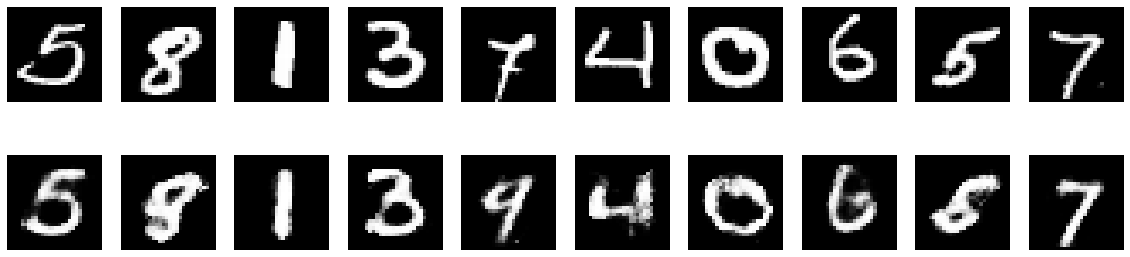

In [14]:
X_sample = np.random.permutation(X_test)[:10]
X_pred   = model.predict(X_sample)

plt.figure(figsize=(20,5))
for i in range(len(X_sample)):
    plt.subplot(2,len(X_sample),i+1)
    plt.imshow(X_sample[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.subplot(2,len(X_sample),len(X_sample)+i+1)
    plt.imshow(X_pred[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")

### show the weights

In [13]:
fl = K.function([model.input], [avg_latent_activations])
fl(X_train)

[array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.2803953 , 0.        , 0.        ,
        0.29372954, 0.13266522, 0.        , 0.        , 0.        ,
        0.        , 0.48692092, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.39722648, 0.42824036, 0.        , 0.        ,
        0.        , 0.5167825 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.27563462, 0.        , 0.        , 0.281553  , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       dtype=float32)]

### show activations in latent space

you should get something similar to this, indicating a much more sparse representation

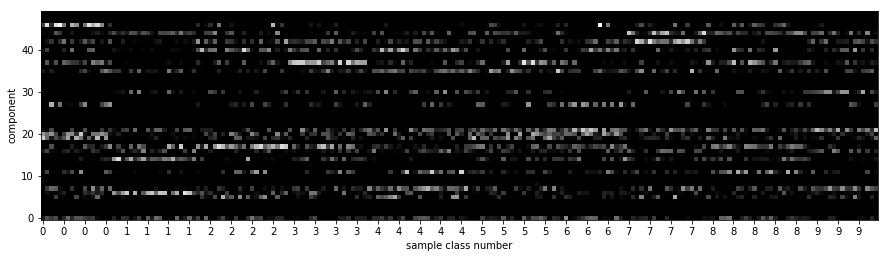

In [14]:
from IPython.display import Image
Image(filename='local/imgs/ae_sparse_activations.png')

encoded data size (200, 50)
mean activation at encoder 0.061


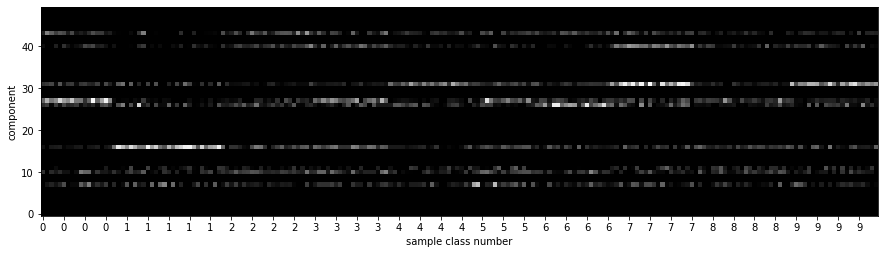

In [15]:
idxs = np.random.permutation(len(X_test))[:200]
idxs = idxs[np.argsort(y_test[idxs])]
y_sample = y_test[idxs]
X_sample = X_test[idxs]

l0_output = K.function([model.input], [encoder])
X_sample_encoded = l0_output([X_sample])[0]
print("encoded data size", X_sample_encoded.shape)
plt.figure(figsize=(15,10))
plt.imshow(X_sample_encoded.T, cmap=plt.cm.Greys_r, origin="lower")
plt.ylabel("component")
plt.xlabel("sample class number")
plt.xticks(range(len(y_sample))[::5], y_sample[::5]);
print ("mean activation at encoder %.3f"%np.mean(X_sample_encoded))

### show the distribution of activations in latent space

should be quite concentrated at 0

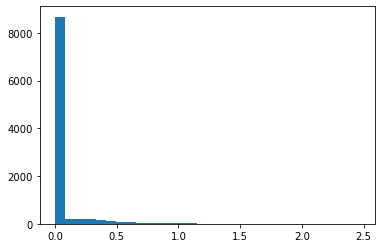

In [16]:
plt.hist(X_sample_encoded.flatten(), bins=30);

### show most representative neuron in latent space for each class

now, representative neurons must show somewhat distinctive shapes for each number


In [17]:
X_train_encoded = l0_output([X_train])[0]

for k, i in enumerate(np.unique(y_train)):
    k = np.zeros(50)
    most_activated_neuron = np.argmax(X_train_encoded[y_train==i].mean(axis=0))
    k[np.argmax(X_train_encoded[y_train==i].mean(axis=0))] = 1
    print ("class %d, most avg activated neuron is %d, with value %.2f"%(i, most_activated_neuron, np.max(X_train_encoded[y_train==i].mean(axis=0))))


class 0, most avg activated neuron is 27, with value 1.25
class 1, most avg activated neuron is 16, with value 1.55
class 2, most avg activated neuron is 43, with value 0.45
class 3, most avg activated neuron is 27, with value 0.89
class 4, most avg activated neuron is 31, with value 1.00
class 5, most avg activated neuron is 27, with value 0.72
class 6, most avg activated neuron is 26, with value 1.02
class 7, most avg activated neuron is 31, with value 1.20
class 8, most avg activated neuron is 16, with value 0.45
class 9, most avg activated neuron is 31, with value 1.07
